In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

# The Secretary Hiring Problem (Optimal Stopping Problem for sequential sampling)

This notebook explores the famous **secretary problem**, a classic problem in optimal stopping theory.

## The Problem

Imagine you need to hire a secretary from 100 candidates. The candidates arrive sequentially, and you must:
- Interview them one at a time in random order
- Immediately accept or reject each candidate (no callbacks)
- Cannot compare candidates you haven't seen yet

**Goal:** Maximize the probability of selecting the best candidate.

## The Optimal Strategy

The solution is to:
1. **Reject the first n candidates** (the "sampling phase") and note the best quality among them
2. **Select the first subsequent candidate** who is better than all candidates in the sampling phase

## Key Question

What value of n maximizes your chance of selecting the best candidate?

**Theoretical answer:** n ≈ N/e ≈ 37% of all candidates, which gives a success probability of approximately 1/e ≈ 37%.

## Model and Monte Carlo Simulation

* The quality of the candidate is represented by a single number, higher numbers represent better candidates
* Randomness will play a role. E.g. sometimes the best candidate comes early in the process and your reject them
* Perform enough trials to give a good estimate of the average outcome for the strategies
* Show that the uptimal stopping strategy is give above and estimate the outcomes to see if they match the theoretical outcome

In [2]:
def sample(decision_point, candidate_pool):
    # best candidate up to decision point
    threshold = np.max(candidate_pool[:decision_point])
    # best candidate across the pool
    highest_quality_score = np.max(candidate_pool) 
    # Choose next best candidate after decision point, better than threshold
    for selected_candidate in range(decision_point, len(candidate_pool)):
        if candidate_pool[selected_candidate] > threshold:
            break
    return np.array([decision_point, selected_candidate, candidate_pool[selected_candidate], 
                     highest_quality_score, candidate_pool[selected_candidate]/highest_quality_score])

In [3]:
candidate_pool_size = 100 # candidate quality scores
trials = 8000 # number of trials used to estimate the average outcome

In [4]:
# zero out the array of trials for recording 5 scores over all possible decision points in the pool
data = np.zeros([trials*(candidate_pool_size-1), 5]) 
secretaries_records = []
for t in range(trials):
    secretaries = np.random.normal(0,1,candidate_pool_size) 
    secretaries_records.extend(secretaries)
    # assume candidates are selected randomly before evalutions start
    # use the same secretary pool to determine outcomes of decision points
    for decision_point in range(0, candidate_pool_size-1):
        data[t*(candidate_pool_size-1) + decision_point] = sample(decision_point+1, secretaries)

In [5]:
df = pd.DataFrame(data, columns=["sample", "selected", "quality", "best", "fraction_best"])
df.describe()

,sample,selected,quality,best,fraction_best
count,792000.000000,792000.000000,792000.000000,792000.000000,792000.000000
mean,50.000000,74.432212,1.063377,2.515636,0.424717
std,28.577398,31.738639,1.357475,0.425262,0.539521
min,1.000000,1.000000,-3.719578,1.142477,-1.627636
25%,25.000000,50.000000,-0.015335,2.211401,-0.005865
50%,50.000000,99.000000,1.318738,2.472747,0.529445
75%,75.000000,99.000000,2.183332,2.771116,1.000000
max,99.000000,99.000000,4.394964,4.394964,1.000000


Random selection of a candidate:

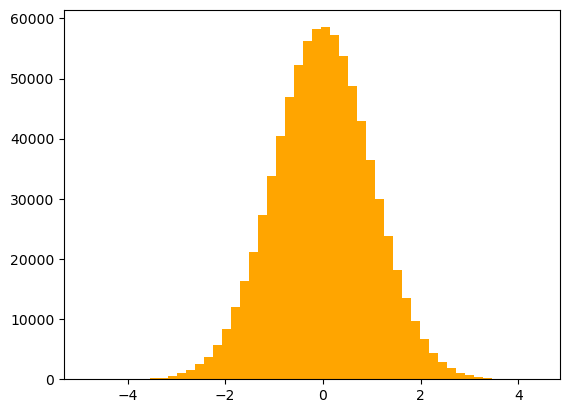

In [6]:
plt.hist(secretaries_records, bins=50, color="orange")
plt.show()

As the threshold moves for 1 to 99. Notice that weighting for even 1 candidate to set the bar improves outcomes significantly. The benefits of waiting are erased in the 60s.

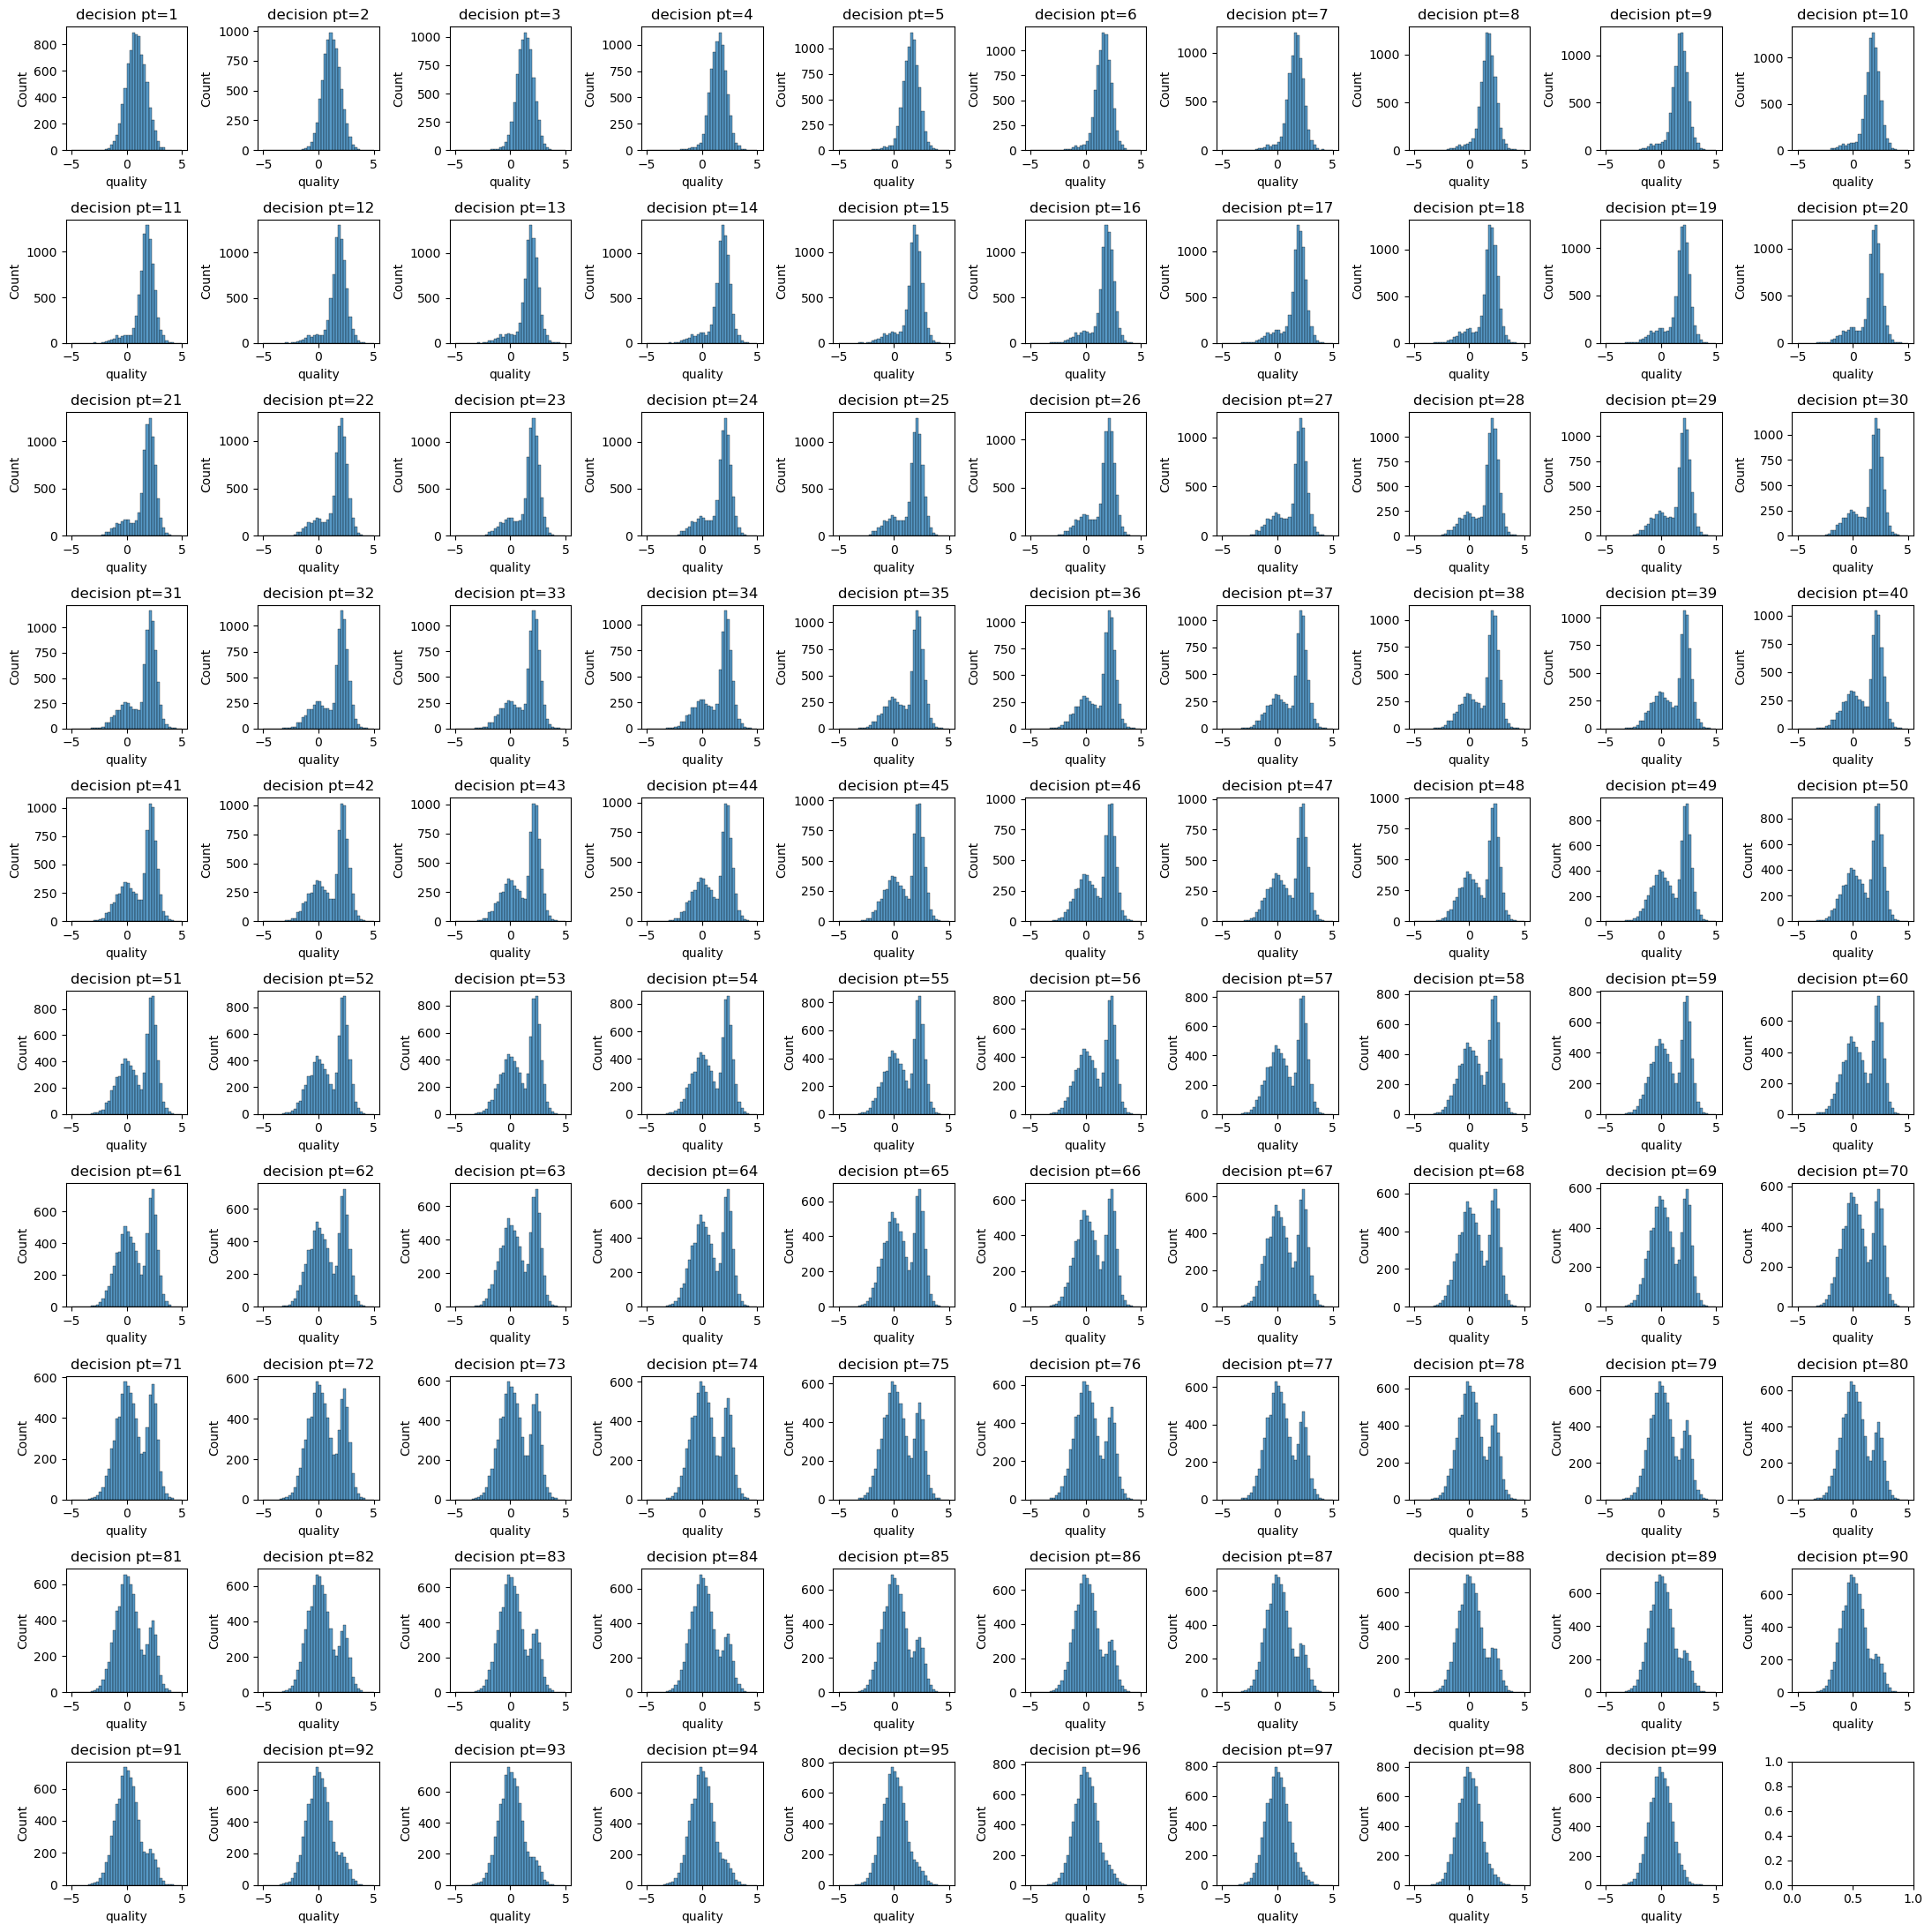

In [7]:
fig, axes = plt.subplots(10, 10, figsize=(22, 22)) # 1 row, 3 columns
# print(axes.shape)
thresh = False
for i in range(1,candidate_pool_size):
    j, k = int((i-1)/10), (i-1)%10
    #print(i,j,k)
    sns.histplot(data=df[df["sample"] == i], x="quality", binrange=(-5,5), bins=40, ax=axes[j,k])
    axes[j,k].set_title(f'decision pt={i}')
plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()

## Plot 1: Probability of Selecting the Best Candidate

This plot shows the **probability of successfully selecting the best candidate** as a function of the sample size (number of candidates rejected in the sampling phase).

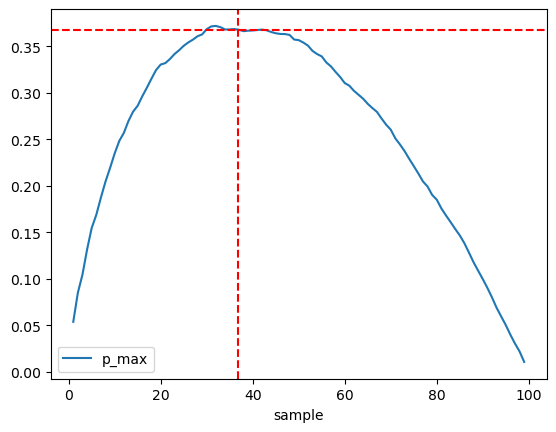

In [8]:
dfmax = df[df["fraction_best"] == 1.0]
dfpmax = dfmax.groupby("sample").size().reset_index()
dfpmax["p_max"] =  dfpmax[0]/trials
ax = dfpmax.plot(x="sample", y="p_max")
ax.axvline(x=100./np.e, color="red", linestyle="--")
ax.axhline(y=1./np.e, color="red", linestyle="--")

### Interpretation:

- **Red dashed lines** mark the theoretical optimum:
  - **Vertical line at N/e ≈ 37**: The optimal number of candidates to reject (sample size)
  - **Horizontal line at 1/e ≈ 37%**: The maximum achievable probability of success
  
- **Peak Performance**: The curve reaches its maximum around sample size 37, confirming the theoretical prediction
- **Too Few Samples**: If you reject too few candidates (left side), you don't have enough information to identify quality
- **Too Many Samples**: If you reject too many candidates (right side), the best candidate may have already passed

This demonstrates that the optimal strategy is to **reject approximately the first 37%** of candidates, then select the next one who's better than all previous ones.

## Plot 2: Average Position of Selected Candidate

This plot shows the **average position (index)** of the candidate selected using each sample size strategy.

Text(0.5, 1.0, 'Sample=13')

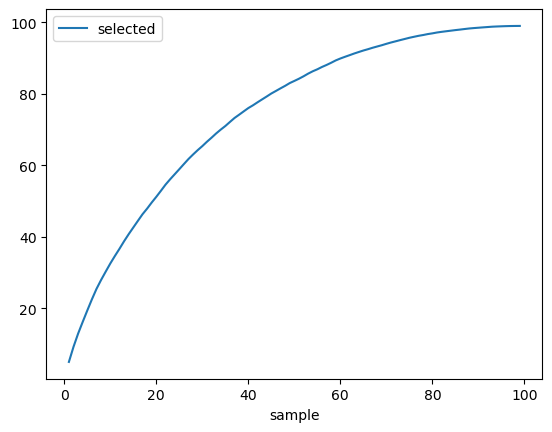

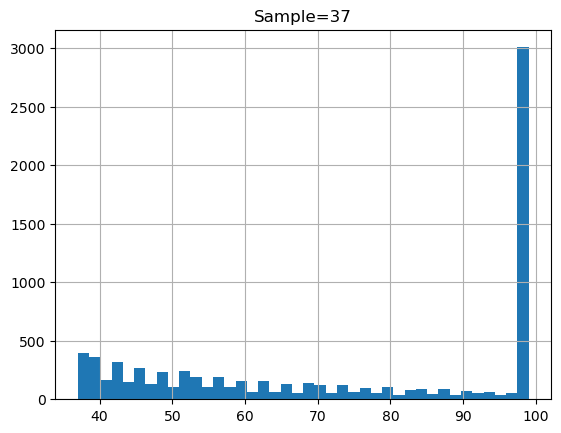

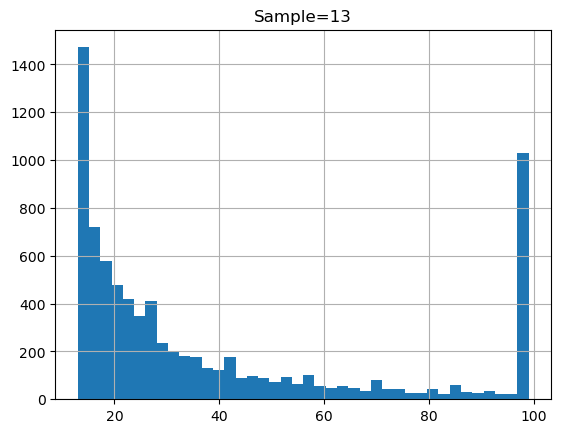

In [9]:
dfgb = df.groupby("sample")["selected"].mean().reset_index()
dfgb.plot(x="sample", y="selected")
df[df["sample"] == 37].hist("selected", bins=40)
plt.title("Sample=37")
df[df["sample"] == 13].hist("selected", bins=40)
plt.title("Sample=13")

### Interpretation:

- **X-axis**: Sample size (number of candidates rejected before selecting)
- **Y-axis**: Average position where selection occurs (1-100)

**Key Observations:**
- **Small sample sizes**: When you reject few candidates (left), you select early (low index) because you quickly find someone better than the small sample
- **Large sample sizes**: When you reject many candidates (right), you're forced to select later (high index) or reach the end
- **Optimal region (around 37)**: Balances between having enough information and having enough remaining candidates

The curve shows that with the optimal strategy, you typically select around position 75 on average, giving you plenty of candidates to evaluate while still having options remaining.

## Plot 3: Average Quality Ratio of Selected Candidate
This plot shows the average quality ratio (selected candidate's quality / best candidate's quality) as a function of sample size.
One might argue this is the optimal stopping point if the goal is to consistenly hire highest possible quality candidates.

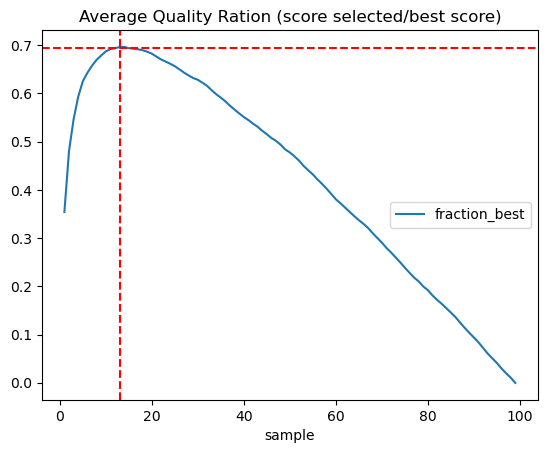

In [13]:
dfgb2 = df.groupby("sample")["fraction_best"].mean().reset_index()
ax = dfgb2.plot(x="sample", y="fraction_best")
ax.axvline(x=13, color="red", linestyle="--")
ax.axhline(y=.695, color="red", linestyle="--")
plt.title("Average Quality Ration (score selected/best score)")
plt.show()

### Interpretation:

- **Y-axis value of 1.0** means you selected the absolute best candidate
- **Y-axis value < 1.0** means you selected a good but not optimal candidate

**Key Observations:**
- The curve has a similar shape to Plot 1, peaking around the optimal sample size of 13
- **Peak around 0.69**: Even with the optimal strategy, on average you get an average candidate whose quality is about 69% of the best
- **This differs from Plot 1**: Plot 1 shows the probability of getting exactly the best (binary success), while this plot shows the average quality of whoever you select

**Why the difference?**




## Summary: Average Quality Ratio at Optimal Stopping Strategy

Calculate the average quality ratio of the selected candidate when using the optimal stopping strategy (rejecting approximately N/e candidates).

In [14]:
# Calculate the optimal sample size
optimal_sample = int(round(candidate_pool_size / np.e, 0))
print(f"Optimal decision point: {optimal_sample} (N/e = {candidate_pool_size/np.e:.2f})")

# Filter data for the optimal stopping strategy
df_optimal = df[df["sample"] == optimal_sample]

# Calculate average quality ratio
avg_quality_ratio = df_optimal["fraction_best"].mean()
std_quality_ratio = df_optimal["fraction_best"].std()

print(f"\nUsing the optimal stopping strategy (rejecting first {optimal_sample} candidates):")
print(f"Average quality ratio of selected candidate: {avg_quality_ratio:.4f}")
print(f"Standard deviation: {std_quality_ratio:.4f}")
print(f"\nThis means on average, the selected candidate's quality is {avg_quality_ratio*100:.1f}% of the best candidate.")
print(f"Theoretical maximizing getting the best candidate: ~1/e ≈ {1/np.e:.4f} (36.8%) is past threshold for getting the best candidate on averate.")


Optimal decision point: 37 (N/e = 36.79)

Using the optimal stopping strategy (rejecting first 37 candidates):
Average quality ratio of selected candidate: 0.5745
Standard deviation: 0.5207

This means on average, the selected candidate's quality is 57.5% of the best candidate.
Theoretical maximizing getting the best candidate: ~1/e ≈ 0.3679 (36.8%) is past threshold for getting the best candidate on averate.
